In [1]:
import os
####*IMPORANT*: Have to do this line *before* importing tensorflow
os.environ['PYTHONHASHSEED']=str(2090341)

In [2]:
"pip install tensorflow-addons"
"pip install tensorflow"
'pip install pydot' #You need to install homebrew to use graphviz 
'pip install pandas'
'pip install numpy'
'pip install keras'
'pip install statsmodels'


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_addons as tfa
import math
import datetime as dt
import random
import copy

from math import sqrt
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense, Dropout
from keras.layers import GaussianNoise
from keras.utils.vis_utils import plot_model


import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller,acf,pacf
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.arima.model import ARIMA,ARIMAResults

In [ ]:
#plt.rcParams['figure.dpi'] = 600

In [3]:
def reset_random_seed():
    sd = 2090341 # Here sd means seed.
    np.random.seed(sd)
    random.seed(sd)
    os.environ['PYTHONHASHSEED']=str(sd)
    tf.random.set_seed(sd)

In [ ]:
## Try running this if results arent same as paper

'''# Seed value
# Apparently you may use different seed values at each stage
seed_value = 2090341

# 1. Set the `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(seed_value)

# 2. Set the `python` built-in pseudo-random generator at a fixed value
random.seed(seed_value)

# 3. Set the `numpy` pseudo-random generator at a fixed value
np.random.seed(seed_value)

# 4. Set the `tensorflow` pseudo-random generator at a fixed value
tf.random.set_seed(seed_value)
# for later versions: 
tf.compat.v1.set_random_seed(seed_value)

# 5. Configure a new global `tensorflow` session
from keras import backend as K
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)
#session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
#sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
#K.set_session(sess)
# for later versions:
'''

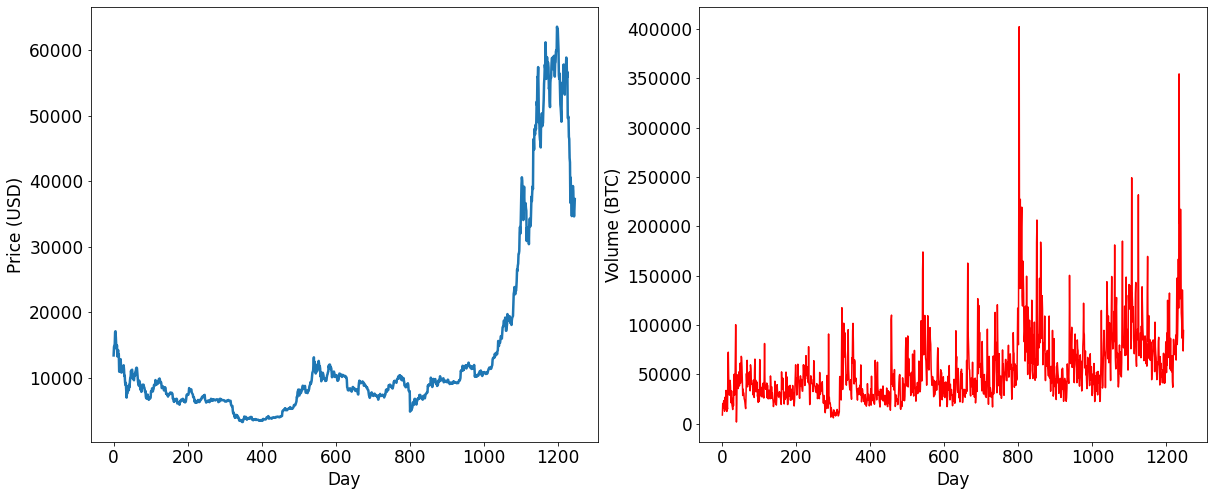

In [4]:
#import data
BTC = pd.read_csv("/Users/denis/Desktop/Masters/Dissertation/CODE/data/BTCUSD_Daily.csv")
plt.rcParams["figure.figsize"] = (20,8)


#Plotting
figure, (fig1, fig2) = plt.subplots(1, 2)
        
fig1.plot(BTC['Close'],linewidth = 2.5)

fig1.set_xlabel('Day', fontsize = 17)
fig1.tick_params(labelsize = 17)
fig1.tick_params(labelsize = 17)

fig2.plot(BTC['Volume'],color = 'red')
fig2.set_xlabel('Day', fontsize = 17)
fig2.set_ylabel('Volume (BTC)', fontsize = 17)
fig2.tick_params(labelsize = 17)
    ## figure out how to save
plt.savefig('/Users/denis/Desktop/Masters/Dissertation/Dissertation Latex/Paper/Figures/BTC PRICE.pdf',format = 'pdf',transparent = False,bbox_inches='tight')
plt.show()

In [5]:
def datawindowingskips(pct,coin,window_size,future_size):
    #Windowsize is how many data days we want to use for prediction, future size is how many days in the future we want to predict for
    #This code scales the data and then performs the data windowing process described in the report  
    n = len(coin)
    m = int(n*pct)
    training_data = coin[['Close','Volume']][0:m].to_numpy()    
    scaler = MinMaxScaler(feature_range=(0,1))
    training_data = scaler.fit_transform(training_data)
    
    val_data = coin[['Close', 'Volume']][m:].to_numpy()
    l = len(val_data)
    unseen_data = val_data[int(l*0.66):]
    val_data = val_data[0:int(l*0.66)]
    val_data = scaler.transform(val_data)
    unseen_data = scaler.transform(unseen_data)


    window_size = window_size
    future_size = future_size
    train_x = []
    train_y = []
    val_x = []
    val_y = []
    unseen_x = []
    unseen_y = []
    
    for i in range(window_size, n, window_size):
        traintemp_x = (training_data[i-window_size:i])
        train_x.append(traintemp_x)
        traintemp_y = (training_data[i:i+future_size])
        train_y.append(traintemp_y)
        
    
    k = len(val_data)
    for i in range(window_size,k,window_size):
        valtemp_x = (val_data[i-window_size:i])
        val_x.append(valtemp_x)
        valtemp_y = (val_data[i:i+future_size])
        val_y.append(valtemp_y)
        
    j = len(unseen_data)
    for i in range(window_size,j,window_size):
        unseentemp_x = (unseen_data[i-window_size:i])
        unseen_x.append(unseentemp_x)
        unseentemp_y = (unseen_data[i:i+future_size])
        unseen_y.append(unseentemp_y)
        

    while len(train_y[-1]) < future_size:
        train_y.pop()
        
    while len(train_x) > len(train_y):
        train_x.pop()
    
    
    while len(val_y[-1]) < future_size:
        val_y.pop()
        
    while len(val_x) > len(val_y):
        val_x.pop()
        
        
    while len(unseen_y[-1]) < future_size:
        unseen_y.pop()
        
    while len(unseen_x) > len(unseen_y):
        unseen_x.pop()
    
    train_x = np.array(train_x)
    train_x = train_x.reshape((-1,window_size,training_data.shape[1]))
    train_y = np.array(train_y)
    train_y = train_y[:,:,0]
    train_y = train_y.reshape((-1,future_size,1))
    
    val_x = np.array(val_x)
    val_x = val_x.reshape((-1,window_size,val_data.shape[1]))
    val_y = np.array(val_y)
    val_y = val_y[:,:,0]
    val_y = val_y.reshape((-1,future_size,1))
    
    unseen_x = np.array(unseen_x)
    unseen_x = unseen_x.reshape((-1,window_size,unseen_data.shape[1]))
    unseen_y = np.array(unseen_y)
    unseen_y = unseen_y[:,:,0]
    unseen_y = unseen_y.reshape((-1,future_size,1))
    return train_x,train_y,val_x,val_y,unseen_x,unseen_y,scaler



In [6]:
## ALL MODELS OUTLINED IN THE MODEL BUILDING SECTION (CH 6)

def LSTM1():
    ann = Sequential(name = "LSTM1")
    ann.add(LSTM(200, input_shape = (5, 2), activation = tf.nn.relu, return_sequences = False))
    ann.add(Dense(100, activation  = tf.nn.relu))
    ann.add(Dense(5, activation = tf.nn.relu))
    ann.add(Dense(5, activation = tf.nn.relu))
    return ann


def LSTM2():
    ann = Sequential(name = "LSTM2")
    ann.add(LSTM(200, input_shape = (5, 2), activation = tf.nn.leaky_relu, return_sequences = False))
    ann.add(Dense(100, activation = tf.nn.leaky_relu))
    ann.add(Dense(5, activation = tf.nn.leaky_relu))
    ann.add(Dense(5, activation = tf.nn.leaky_relu))
    return ann



def LSTM3():
    ann = Sequential(name = "LSTM3")
    ann.add(LSTM(200, input_shape = (5, 2), activation = tf.nn.leaky_relu, return_sequences = True))
    ann.add(LSTM(200,activation = tf.nn.leaky_relu))
    ann.add(Dense(100, activation = tf.nn.leaky_relu))
    ann.add(Dense(5, activation = tf.nn.leaky_relu))
    ann.add(Dense(5, activation = tf.nn.leaky_relu))
    return ann

#Not used for report

'''def ANN15():
    ann = Sequential(name =  "ANN15")
    ann.add(LSTM(128, input_shape = (5, 2), activation = tf.nn.leaky_relu, return_sequences = True))
    ann.add(LSTM(64,activation = tf.nn.leaky_relu))
    ann.add(Dense(64, activation = tf.nn.leaky_relu))
    ann.add(Dense(32, activation = tf.nn.leaky_relu))
    ann.add(Dense(5, activation = tf.nn.leaky_relu))
    return ann'''

'''def ANNExtra():
    ann = Sequential(name = "ANNExtra")
    ann.add(LSTM(200, input_shape = (5, 2), activation = tf.nn.leaky_relu, return_sequences = True))
    ann.add(LSTM(200,activation = tf.nn.leaky_relu))
    ann.add(Dense(200, activation = tf.nn.leaky_relu))
    ann.add(Dropout(0.02))
    ann.add(Dense(100, activation = tf.nn.leaky_relu))
    ann.add(Dropout(0.02))
    ann.add(Dense(50, activation = tf.nn.leaky_relu))
    ann.add(Dropout(0.02))
    ann.add(Dense(5, activation = tf.nn.leaky_relu))
    return ann'''



def LSTM4():

    ann = Sequential(name = "LSTM4")
    ann.add(LSTM(200, input_shape = (5, 2), activation = tf.nn.leaky_relu, return_sequences = True))
    ann.add(LSTM(200,activation = tf.nn.leaky_relu))
    ann.add(Dense(100, activation = tf.nn.leaky_relu))
    ann.add(Dense(60, activation = tf.nn.leaky_relu))
    ann.add(Dense(20, activation = tf.nn.leaky_relu))
    ann.add(Dense(5, activation = tf.nn.leaky_relu))
    return ann

''' OLD NOT USED
def ANN2LessNeurons():

    ann = Sequential(name = "ANN2LessNeurons")
    ann.add(LSTM(200, input_shape = (5, 2), activation = tf.nn.leaky_relu, return_sequences = True))
    ann.add(LSTM(128,activation = tf.nn.leaky_relu))
    ann.add(Dense(88, activation = tf.nn.leaky_relu))
    ann.add(Dense(54, activation = tf.nn.leaky_relu))
    ann.add(Dense(16, activation = tf.nn.leaky_relu))
    ann.add(Dense(5, activation = tf.nn.leaky_relu))
    return ann
'''



def LSTM5():
    ann = Sequential(name = "LSTM5")
    ann.add(LSTM(200, input_shape = (5, 2), activation = tf.nn.leaky_relu, return_sequences = True))
    ann.add(LSTM(200,activation = tf.nn.leaky_relu))
    ann.add(Dense(100, activation = tf.nn.leaky_relu))
    ann.add(Dropout(0.3))
    ann.add(Dense(60, activation = tf.nn.leaky_relu))
    ann.add(Dropout(0.3))
    ann.add(Dense(20, activation = tf.nn.leaky_relu))
    ann.add(Dropout(0.3))
    ann.add(Dense(5, activation = tf.nn.leaky_relu))
    return ann


def ANN35():
    ann = Sequential(name = "ANN35")
    ann.add(LSTM(200, input_shape = (5, 2), activation = tf.nn.leaky_relu, return_sequences = True))
    ann.add(LSTM(200,activation = tf.nn.leaky_relu))
    ann.add(Dense(100, activation = tf.nn.leaky_relu))
    ann.add(Dense(60, activation = tf.nn.leaky_relu))
    ann.add(Dropout(0.05))
    ann.add(Dense(20, activation = tf.nn.leaky_relu))
    ann.add(Dropout(0.05))
    ann.add(Dense(5, activation = tf.nn.leaky_relu))
    return ann






In [7]:
#plots of the network architectures
#requires homebrew and the installation of pydot and graphviz, https://formulae.brew.sh/formula/graphviz this will give an error if you dont have graphviz and pydot so do not 
#run it otherwise

lstm1 = LSTM1()
dot_img_file = '/Users/denis/Desktop/Masters/Dissertation/Dissertation Latex/Paper/Figures/model_0.pdf'
tf.keras.utils.plot_model(lstm1, show_shapes=True,rankdir='TB',to_file=dot_img_file)
lstm2 = LSTM2()
dot_img_file = '/Users/denis/Desktop/Masters/Dissertation/Dissertation Latex/Paper/Figures/model_0Leaky.pdf'
tf.keras.utils.plot_model(lstm2, show_shapes=True,rankdir='TB',to_file=dot_img_file)
lstm3 = LSTM3()
dot_img_file = '/Users/denis/Desktop/Masters/Dissertation/Dissertation Latex/Paper/Figures/model_1.pdf'
tf.keras.utils.plot_model(lstm3, show_shapes=True,rankdir='TB',to_file=dot_img_file)
lstm4 = LSTM4()
dot_img_file = '/Users/denis/Desktop/Masters/Dissertation/Dissertation Latex/Paper/Figures/model_2.pdf'
tf.keras.utils.plot_model(lstm4, show_shapes=True,rankdir='TB',to_file=dot_img_file)
lstm5 = LSTM5()
dot_img_file = '/Users/denis/Desktop/Masters/Dissertation/Dissertation Latex/Paper/Figures/model_3.pdf'
tf.keras.utils.plot_model(lstm5, show_shapes=True,rankdir='TB',to_file=dot_img_file)

In [8]:
#set learning rate for each epoch
def scheduler(epoch):
    lr = 0.00001
    return lr

callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [9]:
#create the training,validation and unseen data

train_x,train_y,val_x,val_y,unseen_x,unseen_y,scaler = datawindowingskips(0.9,BTC,5,5)

In [10]:
def BuildModel(networkname,train_x,train_y,val_x,val_y):
    #set seed for reproducible results
    reset_random_seed()
    #get the name of the network we want to train
    BTC_ANN = networkname()
    epochs = [i for i in range(1, 501, 1)]
    #compiles
    BTC_ANN.compile(optimizer = tf.keras.optimizers.Adam(), loss = 'mse', metrics = tf.keras.metrics.RootMeanSquaredError())
    BTC_history = BTC_ANN.fit(train_x,train_y, epochs = 500, validation_data = (val_x, val_y), callbacks=[callback],verbose = 0)
    
    history = BTC_history.history

    loss = history["loss"]
    val_loss = history["val_loss"]
    RMSE = history["root_mean_squared_error"]
    val_RMSE = history["val_root_mean_squared_error"]
        
    #Plotting
    fig,(ax1,ax3) = plt.subplots(1,2)

    fig.set_figheight(7)
    fig.set_figwidth(16)

    color = 'tab:blue'
    ax1.set_xlabel('Epoch',fontsize = 19)
    ln1 = ax1.plot(epochs, loss, color = color,label = 'Training Loss (MSE)',linewidth = 4)
    ax1.tick_params(axis ='y', labelcolor = color,labelsize = 19)
    ax1.tick_params(axis ='x',labelsize = 19)
    ax1.set_title('Loss (MSE)',fontsize = 18)
    ax2 = ax1.twinx()  

    color = 'tab:red'
    ln2 = ax2.plot(epochs, val_loss, color = color, label = 'Validation Loss (MSE)',linewidth = 4)
    ax2.set_xlabel('Epoch',fontsize = 19)
    ax2.tick_params(axis ='y', labelcolor = color,labelsize = 19)
    lns1 = ln1+ln2
    labs = [l.get_label() for l in lns1]
    ax2.legend(lns1,labs, prop={'size': 17} )

    color = 'tab:blue'
    ax3.set_xlabel('Epoch',fontsize = 19)
    ln3 = ax3.plot(epochs, RMSE, color = color,label = 'Training RMSE',linewidth = 4)
    ax3.tick_params(axis ='y', labelcolor = color,labelsize = 19)
    ax3.tick_params(axis ='x',labelsize = 19)
    ax3.set_title('RMSE',fontsize = 18)

    ax4 = ax3.twinx()  

    color = 'tab:red'
    ln4 = ax4.plot(epochs, val_RMSE, color = color, label = 'Validation RMSE',linewidth = 4)
    ax4.set_xlabel('Epoch',fontsize = 19)
    ax4.tick_params(axis ='y', labelcolor = color,labelsize = 19)
    lns2 = ln3+ln4
    labs2 = [l.get_label() for l in lns2]
    ax4.legend(lns2,labs2, prop={'size': 17} )

    ax1.set_xlim(0,500)
    ax2.set_xlim(0,500)
    ax3.set_xlim(0,500)
    ax4.set_xlim(0,500)
    ax1.set_ylim((0,max(loss)+0.01))
    ax3.set_ylim((0,max(RMSE)+0.05))
    ax2.set_ylim((0,max(val_loss)+0.1))
    ax4.set_ylim((0,max(val_RMSE)+0.1))
    fig.tight_layout(pad =3.0)
    
    
    a = BTC_ANN.name
    plt.savefig('/Users/denis/Desktop/Masters/Dissertation/Dissertation Latex/Paper/Figures/%s.pdf'%a,transparent = False,bbox_inches='tight')
    plt.show()
    
    return BTC_ANN

In [ ]:
#Training LSTM1 to LSTM5

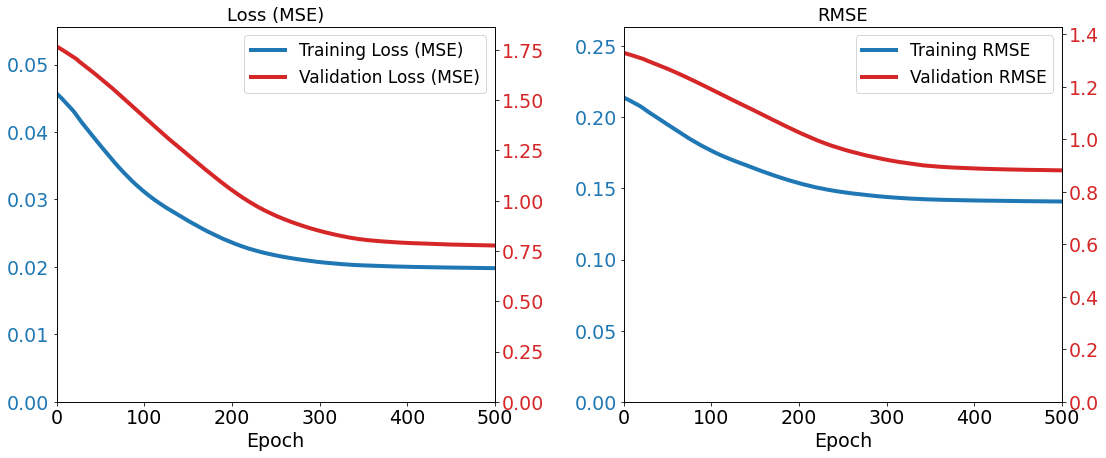

In [11]:
BTC_LSTM1 = BuildModel(LSTM1,train_x,train_y,val_x,val_y) #Builds the specified model

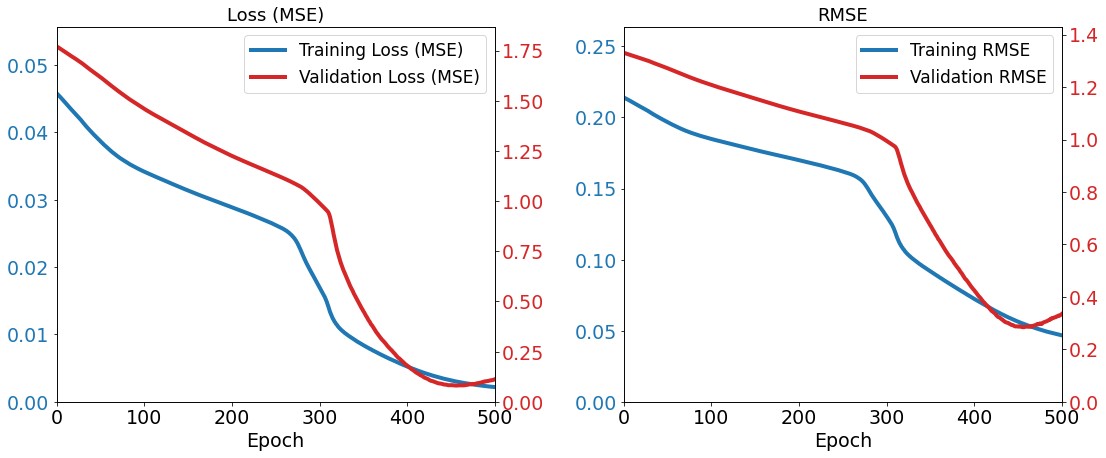

In [12]:
BTC_LSTM2 = BuildModel(LSTM2,train_x,train_y,val_x,val_y)

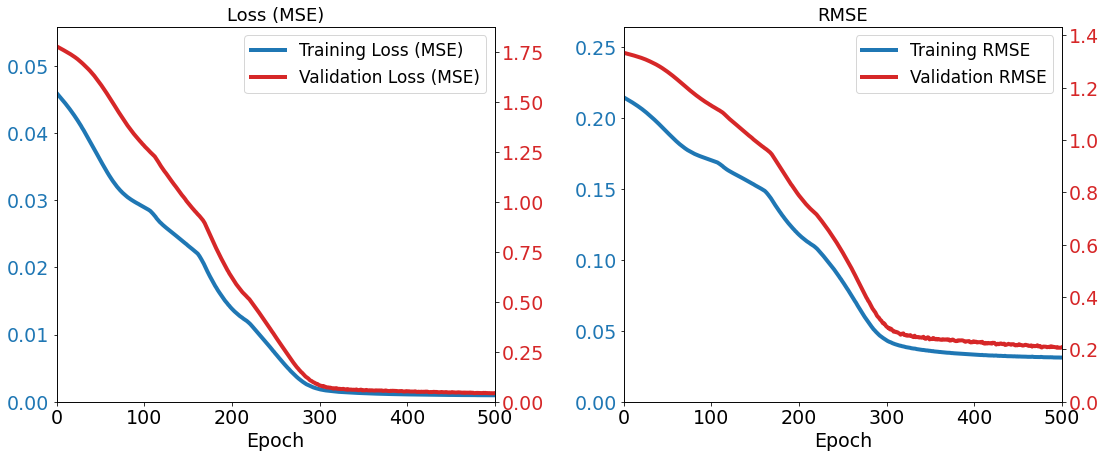

In [13]:
BTC_LSTM3 = BuildModel(LSTM3,train_x,train_y,val_x,val_y)

In [ ]:
'''BTC_LSTM1 = BuildModel(ANN15,train_x,train_y,val_x,val_y)'''

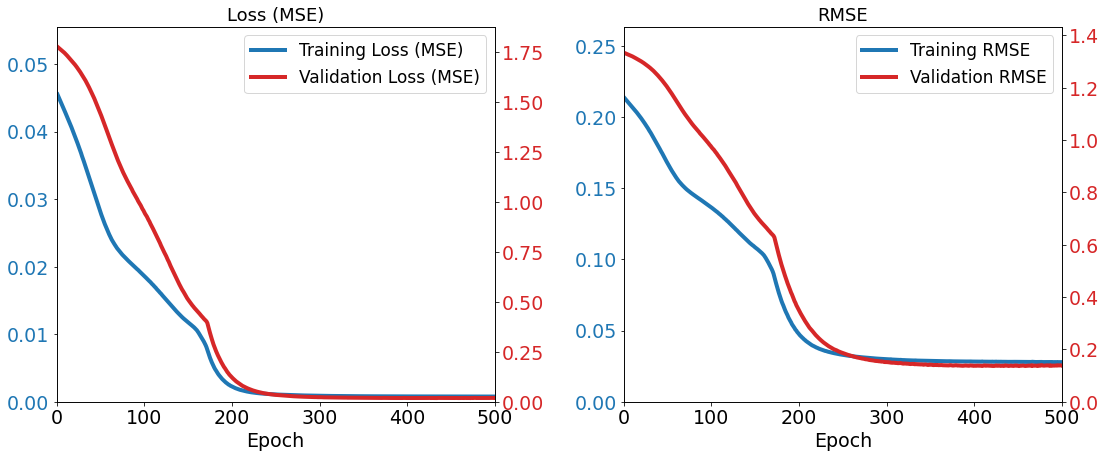

In [14]:
BTC_LSTM4 = BuildModel(LSTM4,train_x,train_y,val_x,val_y)

In [ ]:
'''BTC_ANN2LessNeurons = BuildModel(ANN2LessNeurons,train_x,train_y,val_x,val_y)'''

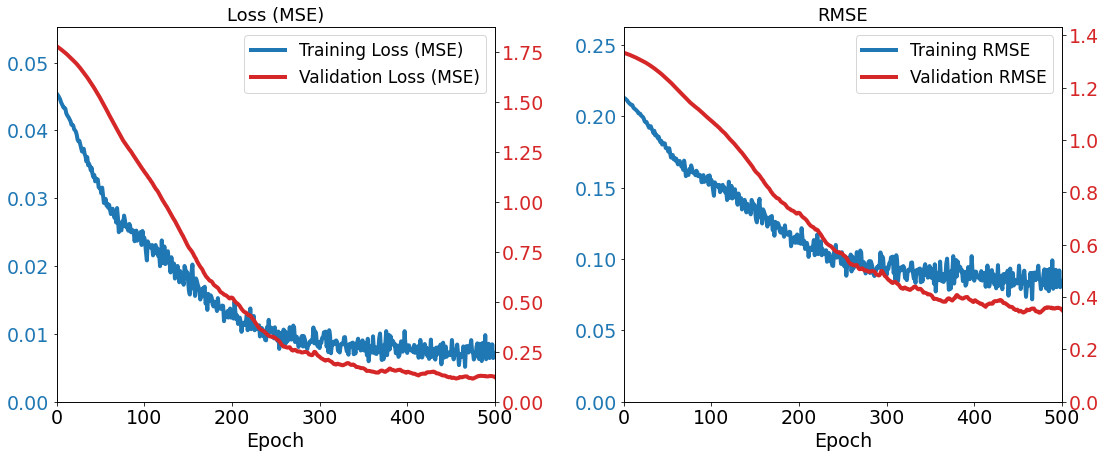

In [15]:
BTC_LSTM5 = BuildModel(LSTM5,train_x,train_y,val_x,val_y)

In [ ]:
'''BTC_LSTM6 = BuildModel(ANN35,train_x,train_y,val_x,val_y)'''

In [16]:
#Take first 15 days of unseen data (3x5 = 15)
unseen_x_15 = unseen_x[0:3:]
unseen_y_15 = unseen_y[0:3:]

In [17]:

#Out of sample predictions RMSE for LSTMs

print("Metrics for ANN0 = ", BTC_LSTM1.evaluate(unseen_x_15,unseen_y_15), "\n")
print("Metrics for ANN0Leaky = ",BTC_LSTM2.evaluate(unseen_x_15,unseen_y_15),"\n")
print("Metrics for ANN1 = ",BTC_LSTM3.evaluate(unseen_x_15,unseen_y_15),"\n")
#print("Metrics for ANN15 = ",BTC_ANN15.evaluate(unseen_x_15,unseen_y_15),"\n")
print("Metrics for ANN2 = ",BTC_LSTM4.evaluate(unseen_x_15,unseen_y_15),"\n")
#print("Metrics for ANN2LessNeurons = ",BTC_ANN2LessNeurons.evaluate(unseen_x_15,unseen_y_15),"\n")
print("Metrics for ANN3 = ",BTC_LSTM5.evaluate(unseen_x_15,unseen_y_15),"\n")

1/1 [==============================] - 0s 153ms/step - loss: 0.8663 - root_mean_squared_error: 0.9307
Metrics for ANN0 =  [0.8662746548652649, 0.9307388067245483] 

1/1 [==============================] - 0s 99ms/step - loss: 0.1121 - root_mean_squared_error: 0.3348
Metrics for ANN0Leaky =  [0.11207602173089981, 0.3347775638103485] 

1/1 [==============================] - 0s 170ms/step - loss: 0.0381 - root_mean_squared_error: 0.1953
Metrics for ANN1 =  [0.03813343122601509, 0.1952778398990631] 

1/1 [==============================] - 0s 200ms/step - loss: 0.0139 - root_mean_squared_error: 0.1179
Metrics for ANN2 =  [0.013905774801969528, 0.11792275309562683] 

1/1 [==============================] - 0s 24ms/step - loss: 0.1302 - root_mean_squared_error: 0.3608
Metrics for ANN3 =  [0.1301833838224411, 0.3608093559741974] 



In [18]:
BTC_LSTM4.summary() #Summary of network

Model: "LSTM4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_12 (LSTM)               (None, 5, 200)            162400    
_________________________________________________________________
lstm_13 (LSTM)               (None, 200)               320800    
_________________________________________________________________
dense_26 (Dense)             (None, 100)               20100     
_________________________________________________________________
dense_27 (Dense)             (None, 60)                6060      
_________________________________________________________________
dense_28 (Dense)             (None, 20)                1220      
_________________________________________________________________
dense_29 (Dense)             (None, 5)                 105       
Total params: 510,685
Trainable params: 510,685
Non-trainable params: 0
_______________________________________________________

In [19]:
#Get predicted values for LSTM4 on 15 days
predicted_values_scaled = BTC_LSTM4.predict(unseen_x_15)

In [20]:
## PREDICTIONS ON UNSEEN SET FIRST 15 DAYS

## MAKE SURE YOU CHANGE MODEL NAME
BTC_LSTM4.evaluate(unseen_x_15,unseen_y_15)
predicted_values_scaled = BTC_LSTM4.predict(unseen_x_15)


1/1 [==============================] - 0s 32ms/step - loss: 0.0139 - root_mean_squared_error: 0.1179


In [21]:
unseen_y_15 = unseen_y_15.reshape(unseen_y_15.shape[0],unseen_y_15.shape[1]) #get the 15 days for the target(real prices) for comparison

In [22]:
#Get parameters to inverse scaling carried out on the data
smin = scaler.min_[0]
sscale = scaler.scale_[0]
sdatamin = scaler.data_min_[0]
sdatamax= scaler.data_max_[0]

scale2 = MinMaxScaler()
scale2.min_,scale2.scale_=smin,sscale

In [23]:
###INVERSE the scaling to get the unscaled prices

predicted_values = scale2.inverse_transform(predicted_values_scaled)
predicted_values

actual_values = scale2.inverse_transform(unseen_y_15)
actual_values

array([[50047.84, 49066.77, 54001.39, 55011.97, 54846.22],
       [53555.  , 57694.27, 57800.37, 56578.21, 57169.39],
       [53200.01, 57436.11, 56393.68, 57314.75, 58862.05]])

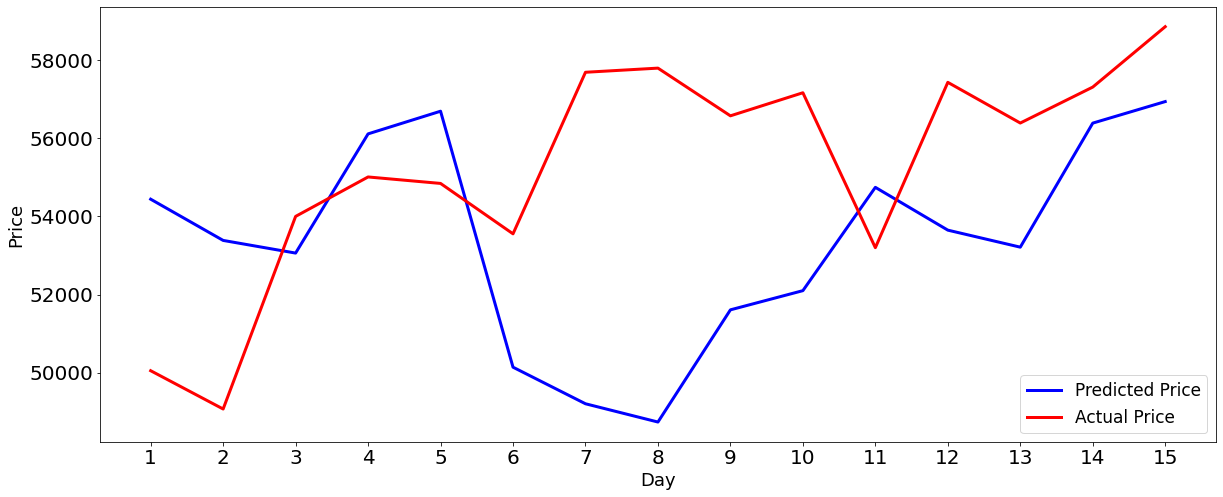

In [24]:
a = np.arange(1,16)
plt.plot(a,predicted_values.reshape(-1),label = 'Predicted Price', linewidth = 3,color = 'blue')
plt.plot(a,actual_values.reshape(-1), label = 'Actual Price', linewidth = 3, color = 'red')
plt.xlabel("Day",fontsize = 18)
plt.ylabel("Price",fontsize = 18)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xticks(np.arange(1, 16, step=1))
plt.legend(loc = 4, prop={'size': 17})


plt.savefig('/Users/denis/Desktop/Masters/Dissertation/Dissertation Latex/Paper/Figures/FinalModelPredictions.pdf',transparent = False,bbox_inches='tight')




In [ ]:
########### ROBUSTNESS TESTS NOISE INJECTION FIRST

In [77]:
train_x, train_y, val_x, val_y,unseen_x,unseen_y,scaler = datawindowingskips(0.9,BTC,5,5) #Reset Training and validation

In [78]:
def noiseinjectiontrain(x_input,y_input, noise_strength, noise_frequency):
    np.random.seed(2090341)
    random.seed(2090341)
    x = copy.deepcopy(x_input)
    y = copy.deepcopy(y_input)
    n = x.shape[0]
    ## choose noise_freq random numbers from (0 to n) and randomly inject some noise into one day of the data
    indices = np.arange(1,n-1)
    random.shuffle(indices)
    indices = indices[0:noise_frequency]
    #print(indices)
    m = len(indices)
    #print(m)
    ### generate random noise 
    noise = np.random.normal(0,noise_strength,len(indices))
    #print(noise) uncomment this to see the noise added
    
    ### add noise to 5 day data need to do it for the x data and y data
    #choose where to randomly insert data where to insert data
    for i in range(m):
        j = random.randint(0,4)
        k = indices[i]
        
        #print(y[k-1,j,0], ' Y BEFORE VALUE')
        y[k-1,j,0] = y[k-1,j,0] + noise[i]
        #print(y[k-1,j,0], ' Y AFTER VALUE')
    
        #print(x[k,j,0], 'X BEFORE VALUE')
        x[k,j,0] = x[k,j,0] + noise[i]
       # print(x[k,j,0], 'X AFTER VALUE')
    #plot the noise

    #plt.plot(y.reshape(-1))
    return x,y
## Adds noise to the validation set (not used in report so ignore)
def noiseinjectionvalidation(x_input,y_input, noise_strength, noise_frequency):
    np.random.seed(2090341)
    random.seed(2090341)
    x = copy.deepcopy(x_input)
    y = copy.deepcopy(y_input)
    n = x.shape[0]
    ## choose noise_freq random numbers from (0 to n) and randomly inject some noise into one day of the data
    indices = np.arange(1,n-1)
    random.shuffle(indices)
    indices = indices[0:noise_frequency]
    print(indices)
    m = len(indices)
    print(m)
    ### generate random noise 
    noise = np.random.normal(0,noise_strength,len(indices))
    print(noise)
    
    ### add noise to 5 day data need to do it for the x data and y data
    #choose where to randomly insert data where to insert data
    for i in range(m):
        j = random.randint(0,4)
        k = indices[i]
        
        #print(y[k-1,j,0], ' Y BEFORE VALUE')
        y[k-1,j,0] = y[k-1,j,0] + noise[i]
        #print(y[k-1,j,0], ' Y AFTER VALUE')
    
        #print(x[k,j,0], 'X BEFORE VALUE')
        x[k,j,0] = x[k,j,0] + noise[i]
       # print(x[k,j,0], 'X AFTER VALUE')
    #plot the noise

    #plt.plot(y.reshape(-1))
    return x,y





In [79]:
def LSTM4():

    ann = Sequential(name = "LSTM4")
    ann.add(LSTM(200, input_shape = (5, 2), activation = tf.nn.leaky_relu, return_sequences = True))
    ann.add(LSTM(200,activation = tf.nn.leaky_relu))
    ann.add(Dense(100, activation = tf.nn.leaky_relu))
    ann.add(Dense(60, activation = tf.nn.leaky_relu))
    ann.add(Dense(20, activation = tf.nn.leaky_relu))
    ann.add(Dense(5, activation = tf.nn.leaky_relu))
    return ann



In [80]:
def BuildModel(networkname,train_x,train_y,val_x,val_y):
    #Same as older BUildModel function
    reset_random_seed()
    BTC_ANN = networkname()
    BTC_ANN.compile(optimizer = tf.keras.optimizers.Adam(), loss = 'mse', metrics = tf.keras.metrics.RootMeanSquaredError())
    BTC_history = BTC_ANN.fit(train_x,train_y, epochs = 500, validation_data = (val_x, val_y), callbacks=[callback],verbose = 0)
    
    history = BTC_history.history

    loss = history["loss"]
    val_loss = history["val_loss"]

    RMSE = history["root_mean_squared_error"]
    val_RMSE = history["val_root_mean_squared_error"]
    
    epochs = range(1, len(loss) + 1)
    
    '''fig1.plot(epochs, loss, label = 'Training Loss (MSE)',linewidth = 2.5)
    fig1.plot(epochs, val_loss, label = 'Validation Loss (MSE)',color = 'red',linewidth = 2.5)
    fig1.set_xlabel('Epochs', fontsize = 16)
    fig1.set_ylabel('Loss (MSE)', fontsize = 16)
    fig1.tick_params(labelsize = 16)
    fig1.legend(prop={'size': 12})

    fig2.plot(epochs, RMSE, label = "Training RMSE",linewidth = 2.5)
    fig2.plot(epochs, val_RMSE, label = "Validation RMSE",color = 'red',linewidth = 2.5)
    fig2.set_xlabel('Epochs', fontsize = 16)
    fig2.set_ylabel('RMSE', fontsize = 16)
    fig2.tick_params(labelsize = 16)
    fig2.legend(prop={'size': 12})'''
    
    fig,(ax1,ax3) = plt.subplots(1,2)

    fig.set_figheight(7)
    fig.set_figwidth(16)

    color = 'tab:blue'
    ax1.set_xlabel('Epoch',fontsize = 19)
    ln1 = ax1.plot(epochs, loss, color = color,label = 'Training Loss (MSE)',linewidth = 4)
    ax1.tick_params(axis ='y', labelcolor = color,labelsize = 19)
    ax1.tick_params(axis ='x',labelsize = 19)
    ax2 = ax1.twinx()  
    ax1.set_title('Loss (MSE)',fontsize = 18)

    color = 'tab:red'
    ln2 = ax2.plot(epochs, val_loss, color = color, label = 'Validation Loss (MSE)',linewidth = 4)
    ax2.set_xlabel('Epoch',fontsize = 19)
    ax2.tick_params(axis ='y', labelcolor = color,labelsize = 19)
    lns1 = ln1+ln2
    labs = [l.get_label() for l in lns1]
    ax2.legend(lns1,labs, prop={'size': 17} )

    color = 'tab:blue'
    ax3.set_xlabel('Epoch',fontsize = 19)
    ln3 = ax3.plot(epochs, RMSE, color = color,label = 'Training RMSE',linewidth = 4)
    ax3.tick_params(axis ='y', labelcolor = color,labelsize = 19)
    ax3.tick_params(axis ='x',labelsize = 19)
    ax3.set_title('RMSE',fontsize = 18)
    ax4 = ax3.twinx()  

    color = 'tab:red'
    ln4 = ax4.plot(epochs, val_RMSE, color = color, label = 'Validation RMSE',linewidth = 4)
    ax4.set_xlabel('Epoch',fontsize = 19)
    ax4.tick_params(axis ='y', labelcolor = color,labelsize = 19)
    lns2 = ln3+ln4
    labs2 = [l.get_label() for l in lns2]
    ax4.legend(lns2,labs2, prop={'size': 17} )

    ax1.set_xlim(0,500)
    ax2.set_xlim(0,500)
    ax3.set_xlim(0,500)
    ax4.set_xlim(0,500)
    ax1.set_ylim((0,max(loss)+0.01))
    ax3.set_ylim((0,max(RMSE)+0.05))
    ax2.set_ylim((0,max(val_loss)+0.1))
    ax4.set_ylim((0,max(val_RMSE)+0.1))
    fig.tight_layout(pad =3.0)
    
    
    
    ## figure out how to save
        

    a = BTC_ANN.name
    ##### NEED TO RENAME PLOT EVERY TIME BUILDMODEL() IS RUN
    plt.savefig('/Users/denis/Desktop/Masters/Dissertation/Dissertation Latex/Paper/Figures/%s NoisyData.pdf'%a,transparent = False,bbox_inches='tight')
    plt.show()
    
    return BTC_ANN

In [81]:
#Adding noise with sigma = 0.01, to 25 days
train_x_noisy,train_y_noisy = noiseinjectiontrain(train_x,train_y,0.01,25)

#getting the unperturbed and noisy data for plot
train_x_rescaled = train_x[:,:,0]
train_x_rescaled = scale2.inverse_transform(train_x_rescaled)
train_x_noisy_rescaled = train_x_noisy[:,:,0]
train_x_noisy_rescaled= scale2.inverse_transform(train_x_noisy_rescaled)

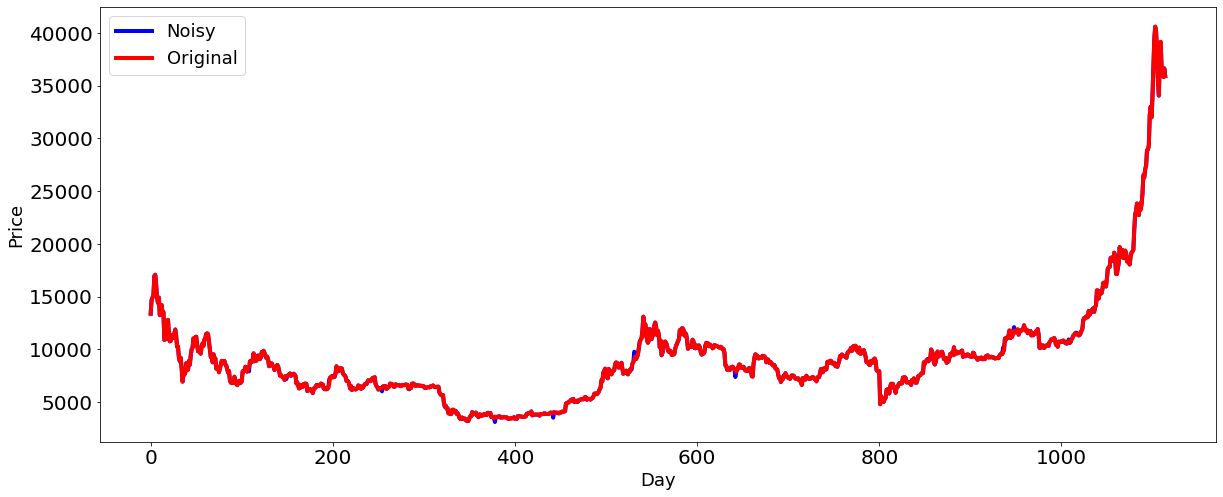

In [82]:
plt.plot(train_x_noisy_rescaled.reshape(-1), label = "Noisy",linewidth=4, color = 'blue')
plt.plot(train_x_rescaled.reshape(-1),label = "Original",linewidth=4,color = 'red')
plt.xlabel("Day",fontsize = 18)
plt.ylabel("Price",fontsize = 18)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(loc = 2,  prop={'size': 18})
plt.savefig('/Users/denis/Desktop/Masters/Dissertation/Dissertation Latex/Paper/Figures/NoiseInjection1.pdf',transparent = False,bbox_inches="tight")

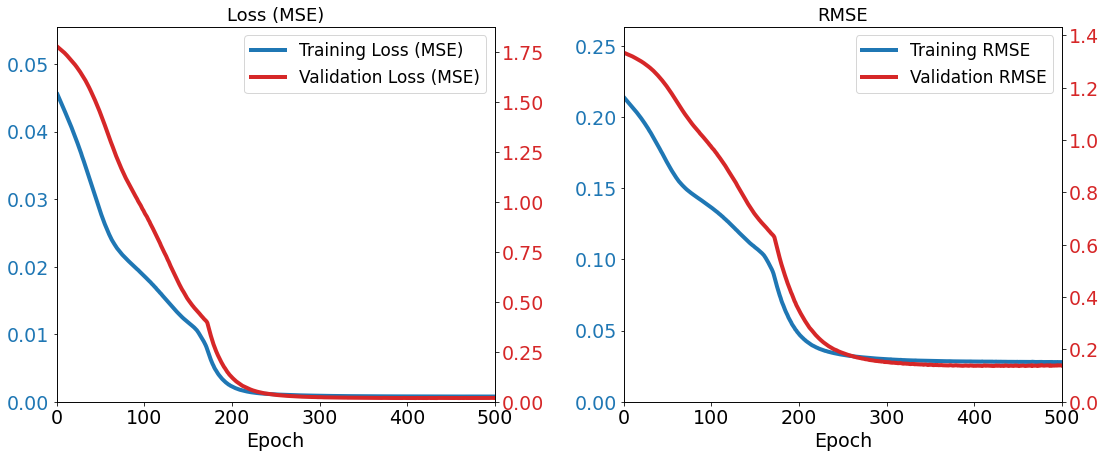

In [83]:
#Building model with noisy training data
BTC_LSTM4Noisy1 = BuildModel(LSTM4,train_x_noisy,train_y_noisy,val_x,val_y)

In [84]:
#Getting RMSE For 15 day ahead out-of-sample predictions

unseen_x_15 = unseen_x[0:3:]
unseen_y_15 = unseen_y[0:3:]

## MAKE SURE YOU CHANGE MODEL NAME
BTC_LSTM4Noisy1.evaluate(unseen_x_15,unseen_y_15)
predicted_values_scaled = BTC_LSTM4Noisy1.predict(unseen_x_15)

#BTC_ANN.summary()

1/1 [==============================] - 0s 33ms/step - loss: 0.0139 - root_mean_squared_error: 0.1179


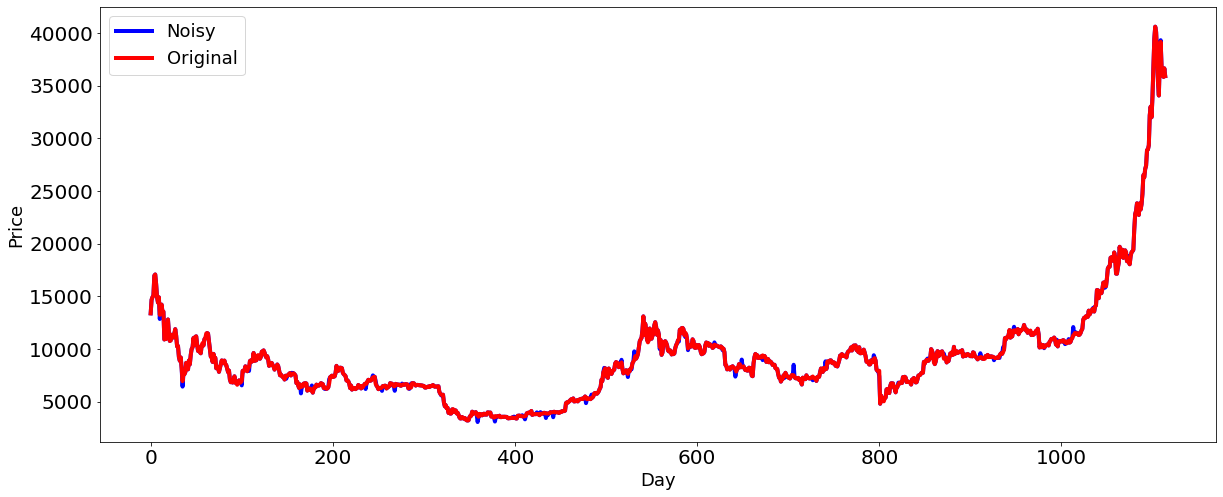

In [85]:
train_x_noisy,train_y_noisy = noiseinjectiontrain(train_x,train_y,0.01,100)

train_x_rescaled = train_x[:,:,0]
train_x_rescaled = scale2.inverse_transform(train_x_rescaled)
train_x_noisy_rescaled = train_x_noisy[:,:,0]
train_x_noisy_rescaled= scale2.inverse_transform(train_x_noisy_rescaled)



plt.plot(train_x_noisy_rescaled.reshape(-1), label = "Noisy",linewidth=4, color = 'blue')
plt.plot(train_x_rescaled.reshape(-1),label = "Original",linewidth=4,color = 'red')
plt.xlabel("Day",fontsize = 18)
plt.ylabel("Price",fontsize = 18)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(loc = 2,  prop={'size': 18})
plt.savefig('/Users/denis/Desktop/Masters/Dissertation/Dissertation Latex/Paper/Figures/NoiseInjection2.pdf',transparent = False,bbox_inches="tight")

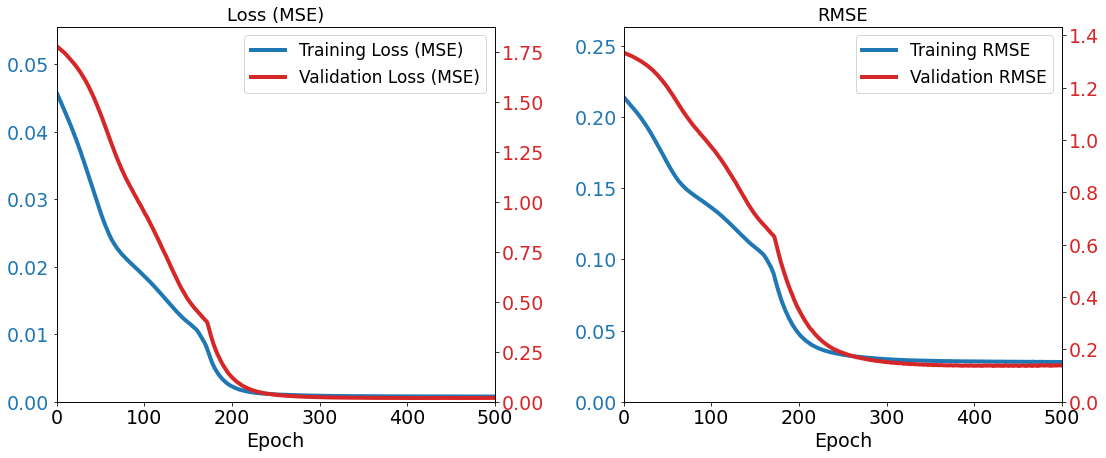

In [86]:
#Same process as before
BTC_LSTM4Noisy2 = BuildModel(LSTM4,train_x_noisy,train_y_noisy,val_x,val_y)

In [87]:
unseen_x_15 = unseen_x[0:3:]
unseen_y_15 = unseen_y[0:3:]

## MAKE SURE YOU CHANGE MODEL NAME
BTC_LSTM4Noisy2.evaluate(unseen_x_15,unseen_y_15)
predicted_values_scaled = BTC_LSTM4Noisy2.predict(unseen_x_15)

#BTC_ANN.summary()

1/1 [==============================] - 0s 25ms/step - loss: 0.0140 - root_mean_squared_error: 0.1182


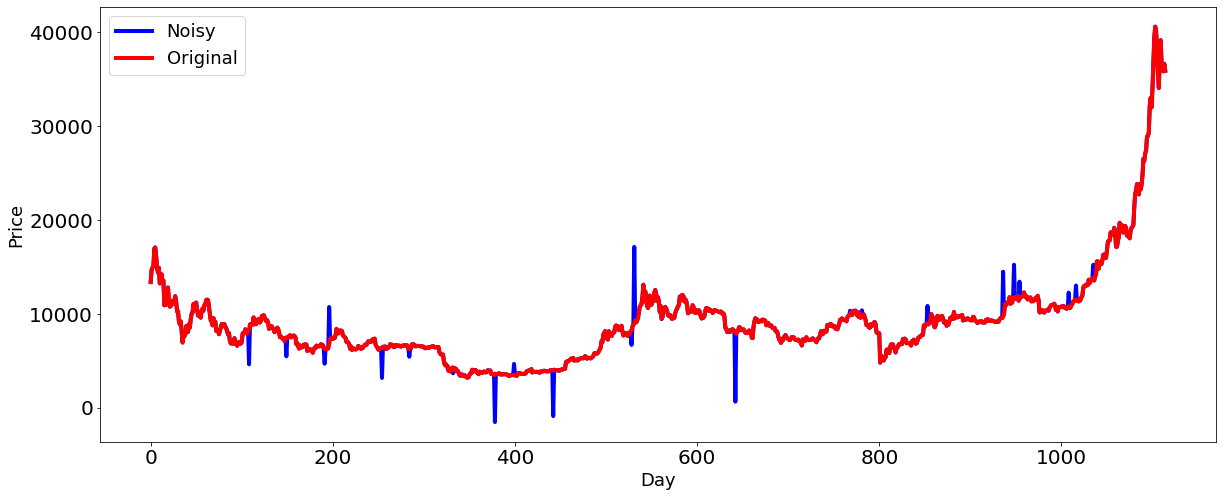

In [88]:
#Not used in report as it isnt interesting so we tried an even more extreme example
train_x_noisy,train_y_noisy = noiseinjectiontrain(train_x,train_y,0.1,25)

train_x_rescaled = train_x[:,:,0]
train_x_rescaled = scale2.inverse_transform(train_x_rescaled)
train_x_noisy_rescaled = train_x_noisy[:,:,0]
train_x_noisy_rescaled= scale2.inverse_transform(train_x_noisy_rescaled)

plt.plot(train_x_noisy_rescaled.reshape(-1), label = "Noisy",linewidth=4, color = 'blue')
plt.plot(train_x_rescaled.reshape(-1),label = "Original",linewidth=4,color = 'red')
plt.xlabel("Day",fontsize = 18)
plt.ylabel("Price",fontsize = 18)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(loc = 2,  prop={'size': 18})
plt.savefig('/Users/denis/Desktop/Masters/Dissertation/Dissertation Latex/Paper/Figures/NoiseInjection3.pdf',transparent = False,bbox_inches="tight")

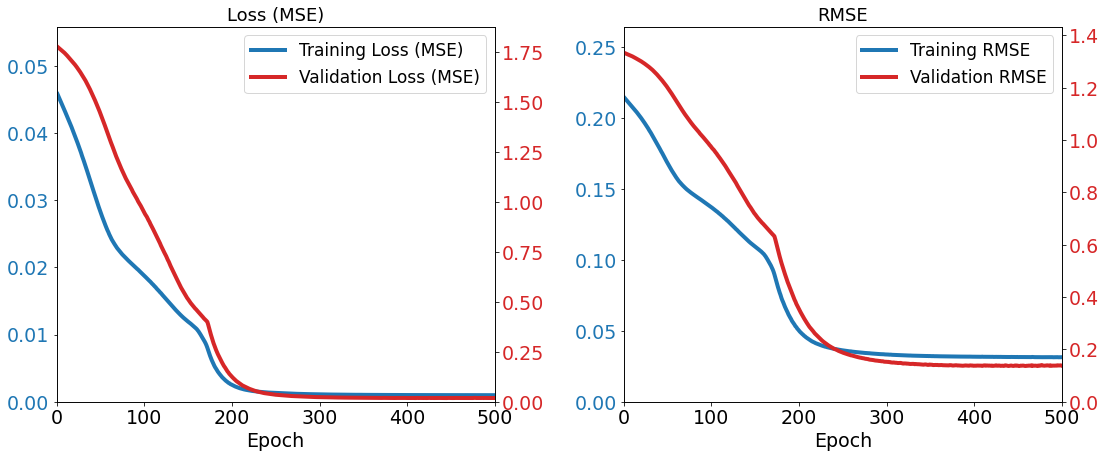

In [89]:
BTC_LSTM4Noisy3 = BuildModel(LSTM4,train_x_noisy,train_y_noisy,val_x,val_y)

In [90]:
unseen_x = unseen_x[0:3:]
unseen_y = unseen_y[0:3:]

## MAKE SURE YOU CHANGE MODEL NAME
BTC_LSTM4Noisy3.evaluate(unseen_x,unseen_y)
predicted_values_scaled = BTC_LSTM4Noisy3.predict(unseen_x)

#BTC_ANN.summary()

1/1 [==============================] - 0s 26ms/step - loss: 0.0138 - root_mean_squared_error: 0.1173


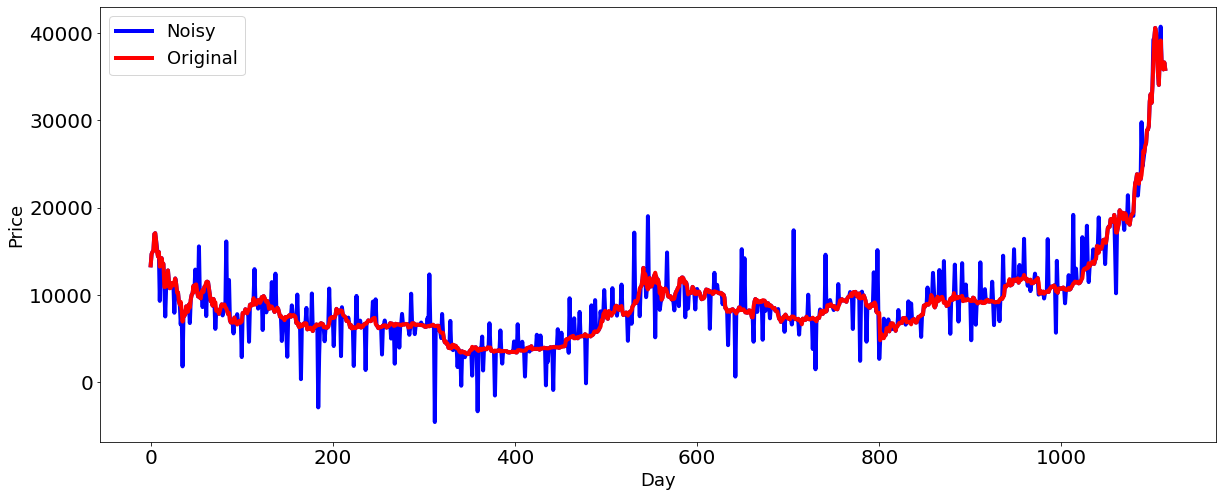

In [91]:
#Third Noisy Data test in report

train_x_noisy,train_y_noisy = noiseinjectiontrain(train_x,train_y,0.1,250)

train_x_rescaled = train_x[:,:,0]
train_x_rescaled = scale2.inverse_transform(train_x_rescaled)
train_x_noisy_rescaled = train_x_noisy[:,:,0]
train_x_noisy_rescaled= scale2.inverse_transform(train_x_noisy_rescaled)

plt.plot(train_x_noisy_rescaled.reshape(-1), label = "Noisy",linewidth=4, color = 'blue')
plt.plot(train_x_rescaled.reshape(-1),label = "Original",linewidth=4,color = 'red')
plt.xlabel("Day",fontsize = 18)
plt.ylabel("Price",fontsize = 18)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(loc = 2,  prop={'size': 18})
plt.savefig('/Users/denis/Desktop/Masters/Dissertation/Dissertation Latex/Paper/Figures/NoiseInjection4.pdf',transparent = False,bbox_inches="tight")

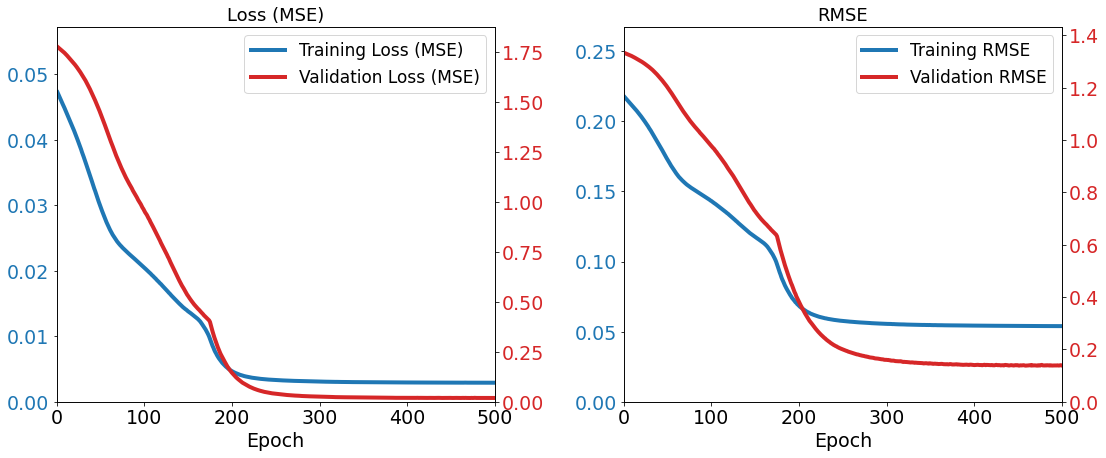

In [92]:
BTC_LSTM4Noisy4 = BuildModel(LSTM4,train_x_noisy,train_y_noisy,val_x,val_y)

In [93]:
unseen_x_15 = unseen_x[0:3:]
unseen_y_15 = unseen_y[0:3:]

## MAKE SURE YOU CHANGE MODEL NAME
BTC_LSTM4Noisy4.evaluate(unseen_x_15,unseen_y_15)
predicted_values_scaled = BTC_LSTM4Noisy4.predict(unseen_x_15)

#BTC_ANN.summary()

1/1 [==============================] - 0s 27ms/step - loss: 0.0137 - root_mean_squared_error: 0.1169


In [48]:
# Testing with noisy training and validation data, not used in report but somewhat interesting, not running it as its not part of the report
'''
train_x_noisy,train_y_noisy = noiseinjectiontrain(train_x,train_y,0.1,250)
val_x_noisy,val_y_noisy = noiseinjectionvalidation(val_x,val_y,0.1,15)
n = len(train_x[:,:,0].reshape(-1))
m = len(val_x[:,:,0].reshape(-1))

indexs = np.arange(n,n+m)

plt.plot(train_y_noisy[:,:,0].reshape(-1), label = "Noisy Training",linewidth = 3, color = 'blue')
plt.plot(train_y[:,:,0].reshape(-1),label = "Original Training",linewidth = 3, color = 'red')
plt.plot(indexs,val_x_noisy[:,:,0].reshape(-1), label = "Noisy Validation", linewidth = 3, color = 'black')
plt.plot(indexs,val_x[:,:,0].reshape(-1), label = "Original Validation", linewidth = 3, color = 'orange')
plt.xlabel("Day",fontsize = 16)
plt.ylabel("Price",fontsize = 16)
plt.title("NoiseInjection",fontsize = 14)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(loc = 2,  prop={'size': 12})
plt.savefig('/Users/denis/Desktop/Masters/Dissertation/Dissertation Latex/Paper/Figures/NoiseInjection5.png',transparent = False,bbox_inches="tight")
'''

'\ntrain_x_noisy,train_y_noisy = noiseinjectiontrain(train_x,train_y,0.1,250)\nval_x_noisy,val_y_noisy = noiseinjectionvalidation(val_x,val_y,0.1,15)\nn = len(train_x[:,:,0].reshape(-1))\nm = len(val_x[:,:,0].reshape(-1))\n\nindexs = np.arange(n,n+m)\n\nplt.plot(train_y_noisy[:,:,0].reshape(-1), label = "Noisy Training",linewidth = 3, color = \'blue\')\nplt.plot(train_y[:,:,0].reshape(-1),label = "Original Training",linewidth = 3, color = \'red\')\nplt.plot(indexs,val_x_noisy[:,:,0].reshape(-1), label = "Noisy Validation", linewidth = 3, color = \'black\')\nplt.plot(indexs,val_x[:,:,0].reshape(-1), label = "Original Validation", linewidth = 3, color = \'orange\')\nplt.xlabel("Day",fontsize = 16)\nplt.ylabel("Price",fontsize = 16)\nplt.title("NoiseInjection",fontsize = 14)\nplt.xticks(fontsize=16)\nplt.yticks(fontsize=16)\nplt.legend(loc = 2,  prop={\'size\': 12})\nplt.savefig(\'/Users/denis/Desktop/Masters/Dissertation/Dissertation Latex/Paper/Figures/NoiseInjection5.png\',transparent 

In [49]:
#BTC_LSTM4NoisyVal = BuildModel(LSTM4,train_x_noisy,train_y_noisy,val_x_noisy,val_y_noisy)

In [50]:
#unseen_x_15 = unseen_x[0:3:]
#unseen_y_15 = unseen_y[0:3:]

## MAKE SURE YOU CHANGE MODEL NAME
#BTC_LSTM4NoisyVal.evaluate(unseen_x_15,unseen_y_15)
#predicted_values_scaled = BTC_ANN2NoisyVal.predict(unseen_x_15)



In [94]:

# MODEL NOISE SECTION

### GAUSSIAN NOISE LAYERS

def LSTM4GaussianLayers():

    ann = Sequential(name = "LSTM43SmallNoise")
    ann.add(LSTM(200, input_shape = (5, 2), activation = tf.nn.leaky_relu, return_sequences = True))
    ann.add(LSTM(200,activation = tf.nn.leaky_relu))
    ann.add(GaussianNoise(0.02))
    ann.add(Dense(100, activation = tf.nn.leaky_relu))
    ann.add(GaussianNoise(0.02))
    ann.add(Dense(60, activation = tf.nn.leaky_relu))
    ann.add(GaussianNoise(0.02))
    ann.add(Dense(20, activation = tf.nn.leaky_relu))
    ann.add(Dense(5, activation = tf.nn.leaky_relu))
    return ann

def LSTM4GaussianLayers2():

    ann = Sequential(name = "LSTM44BigNoise")
    ann.add(LSTM(200, input_shape = (5, 2), activation = tf.nn.leaky_relu, return_sequences = True))
    ann.add(LSTM(200,activation = tf.nn.leaky_relu))
    ann.add(GaussianNoise(0.1))
    ann.add(Dense(100, activation = tf.nn.leaky_relu))
    ann.add(GaussianNoise(0.1))
    ann.add(Dense(60, activation = tf.nn.leaky_relu))
    ann.add(GaussianNoise(0.1))
    ann.add(Dense(20, activation = tf.nn.leaky_relu))
    ann.add(GaussianNoise(0.1))
    ann.add(Dense(5, activation = tf.nn.leaky_relu))
    return ann



#NOISY DENSE LAYERS

def LSTM4DenseGaussian():
    ann = Sequential(name = "LSTM41DenseGaus")
    ann.add(LSTM(200, input_shape = (5, 2), activation = tf.nn.leaky_relu, return_sequences = True))
    ann.add(LSTM(200,activation = tf.nn.leaky_relu))
    ann.add(tfa.layers.NoisyDense(100, activation = tf.nn.leaky_relu, sigma = 0.1))
    ann.add(Dense(60, activation = tf.nn.leaky_relu))
    ann.add(Dense(20, activation = tf.nn.leaky_relu))
    ann.add(Dense(5, activation = tf.nn.leaky_relu))
    return ann

#Not used in report
'''def LSTM4DenseGaussianEnd():
    ann = Sequential(name = "LSTM41DenseGausEnd")
    ann.add(LSTM(200, input_shape = (5, 2), activation = tf.nn.leaky_relu, return_sequences = True))
    ann.add(LSTM(200,activation = tf.nn.leaky_relu))
    ann.add(Dense(100, activation = tf.nn.leaky_relu))
    ann.add(Dense(60, activation = tf.nn.leaky_relu))
    ann.add(tfa.layers.NoisyDense(20, activation = tf.nn.leaky_relu, sigma = 0.1))
    ann.add(Dense(5, activation = tf.nn.leaky_relu))
    return ann'''

def LSTM4DenseGaussian2():
    ann = Sequential(name = "LSTM42DenseGaus")
    ann.add(LSTM(200, input_shape = (5, 2), activation = tf.nn.leaky_relu, return_sequences = True))
    ann.add(LSTM(200,activation = tf.nn.leaky_relu))
    ann.add(tfa.layers.NoisyDense(100, activation = tf.nn.leaky_relu,sigma = 0.1))
    ann.add(tfa.layers.NoisyDense(60, activation = tf.nn.leaky_relu,sigma = 0.1))
    ann.add(tfa.layers.NoisyDense(20, activation = tf.nn.leaky_relu,sigma = 0.1))
    ann.add(Dense(5, activation = tf.nn.leaky_relu))
    return ann

#Also not sued in report
'''
def LSTM4DenseGaussianTEST():
    ann = Sequential(name = "LSTM42DenseGausExtreme")
    ann.add(LSTM(200, input_shape = (5, 2), activation = tf.nn.leaky_relu, return_sequences = True))
    ann.add(LSTM(200,activation = tf.nn.leaky_relu))
    ann.add(tfa.layers.NoisyDense(100, activation = tf.nn.leaky_relu, sigma = 0.9))
    ann.add(tfa.layers.NoisyDense(60, activation = tf.nn.leaky_relu, sigma = 0.9))
    ann.add(Dense(20, activation = tf.nn.leaky_relu))
    ann.add(Dense(5, activation = tf.nn.leaky_relu))
    return ann
    
    '''





'\ndef LSTM4DenseGaussianTEST():\n    ann = Sequential(name = "LSTM42DenseGausExtreme")\n    ann.add(LSTM(200, input_shape = (5, 2), activation = tf.nn.leaky_relu, return_sequences = True))\n    ann.add(LSTM(200,activation = tf.nn.leaky_relu))\n    ann.add(tfa.layers.NoisyDense(100, activation = tf.nn.leaky_relu, sigma = 0.9))\n    ann.add(tfa.layers.NoisyDense(60, activation = tf.nn.leaky_relu, sigma = 0.9))\n    ann.add(Dense(20, activation = tf.nn.leaky_relu))\n    ann.add(Dense(5, activation = tf.nn.leaky_relu))\n    return ann\n    \n    '

In [52]:
##### GAUSSIAN NOISE MODELS

In [95]:
#Setting training data etc as before

train_x, train_y, val_x, val_y,unseen_x,unseen_y,scaler = datawindowingskips(0.9,BTC,5,5)

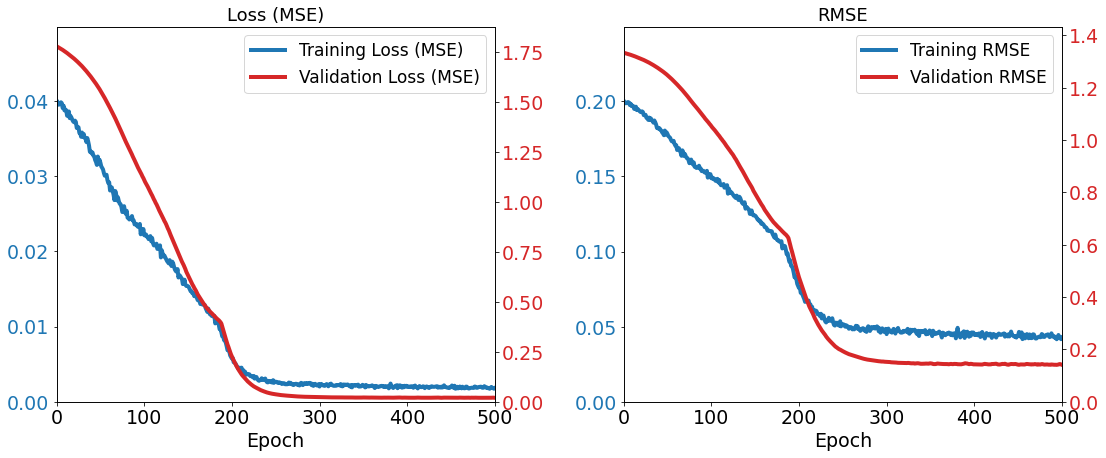

In [96]:
#building noisy model

BTC_LSTM4GaussianLayers = BuildModel(LSTM4GaussianLayers,train_x,train_y,val_x,val_y)

In [97]:
#get RMSE for 15 day ahead predictions

unseen_x_15 = unseen_x[0:3:]
unseen_y_15 = unseen_y[0:3:]

## MAKE SURE YOU CHANGE MODEL NAME
BTC_LSTM4GaussianLayers.evaluate(unseen_x_15,unseen_y_15)
predicted_values_scaled = BTC_LSTM4GaussianLayers.predict(unseen_x_15)



1/1 [==============================] - 0s 28ms/step - loss: 0.0136 - root_mean_squared_error: 0.1166


In [98]:
#repeat for next model
train_x, train_y, val_x, val_y,unseen_x,unseen_y,scaler = datawindowingskips(0.9,BTC,5,5)

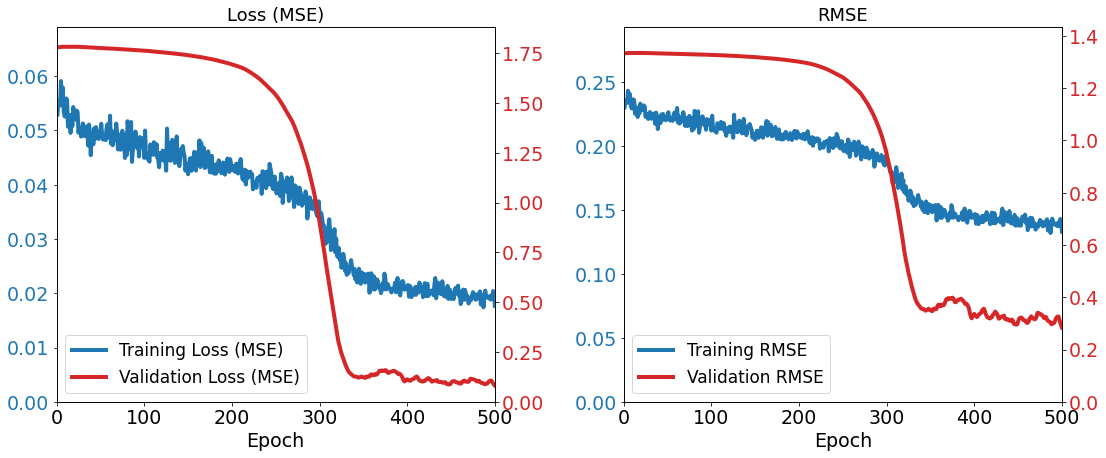

In [99]:
BTC_LSTM4GaussianLayers2 = BuildModel(LSTM4GaussianLayers2,train_x,train_y,val_x,val_y)

In [100]:
unseen_x_15 = unseen_x[0:3:]
unseen_y_15 = unseen_y[0:3:]

## MAKE SURE YOU CHANGE MODEL NAME
BTC_LSTM4GaussianLayers2.evaluate(unseen_x,unseen_y)
predicted_values_scaled = BTC_LSTM4GaussianLayers2.predict(unseen_x_15)



1/1 [==============================] - 0s 26ms/step - loss: 0.1615 - root_mean_squared_error: 0.4019


In [101]:
unseen_x_15.shape

(3, 5, 2)

In [102]:
unseen_y_15 = unseen_y_15.reshape(unseen_y_15.shape[0],unseen_y_15.shape[1])

In [103]:
#Get parameters to inverse scaling
smin = scaler.min_[0]
sscale = scaler.scale_[0]
sdatamin = scaler.data_min_[0]
sdatamax= scaler.data_max_[0]

scale2 = MinMaxScaler()
scale2.min_,scale2.scale_=smin,sscale

In [104]:
###INVERSE

predicted_values = scale2.inverse_transform(predicted_values_scaled)
predicted_values

actual_values = scale2.inverse_transform(unseen_y_15)
actual_values

array([[50047.84, 49066.77, 54001.39, 55011.97, 54846.22],
       [53555.  , 57694.27, 57800.37, 56578.21, 57169.39],
       [53200.01, 57436.11, 56393.68, 57314.75, 58862.05]])

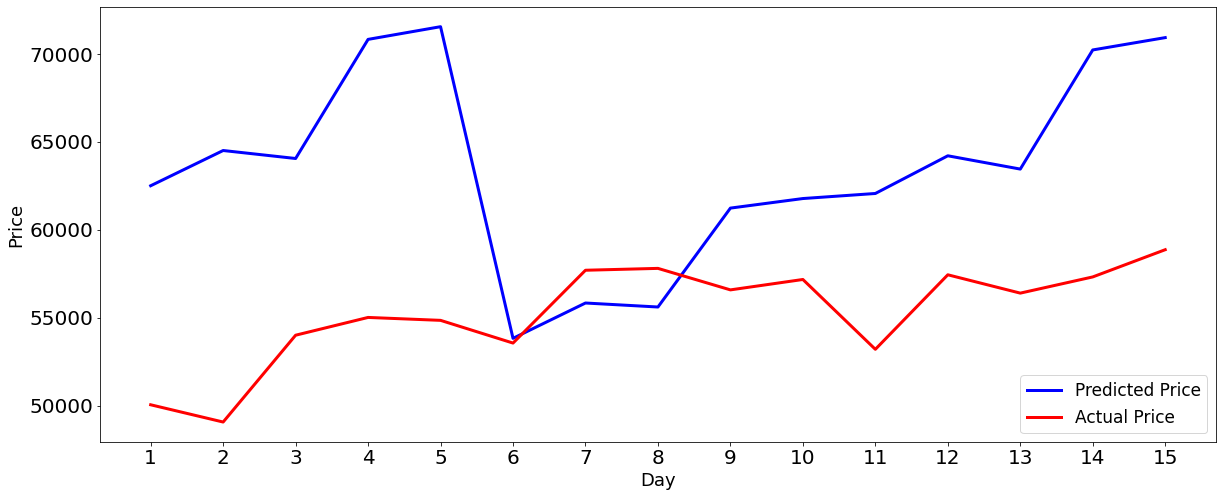

In [105]:

#plot predictions for 15 days out of sample on model with worst RMSE from the Gaussian noise
a = np.arange(1,16)
plt.plot(a,predicted_values.reshape(-1),label = 'Predicted Price', linewidth = 3,color = 'blue')
plt.plot(a,actual_values.reshape(-1), label = 'Actual Price', linewidth = 3, color = 'red')
plt.xlabel("Day",fontsize = 18)
plt.ylabel("Price",fontsize = 18)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xticks(np.arange(1, 16, step=1))
plt.legend(loc = 4, prop={'size': 17})


plt.savefig('/Users/denis/Desktop/Masters/Dissertation/Dissertation Latex/Paper/Figures/GaussianLayers2.pdf',transparent = False,bbox_inches='tight')

In [106]:
#NoisyDense MOdels same as before

In [107]:
train_x, train_y, val_x, val_y,unseen_x,unseen_y,scaler = datawindowingskips(0.9,BTC,5,5)

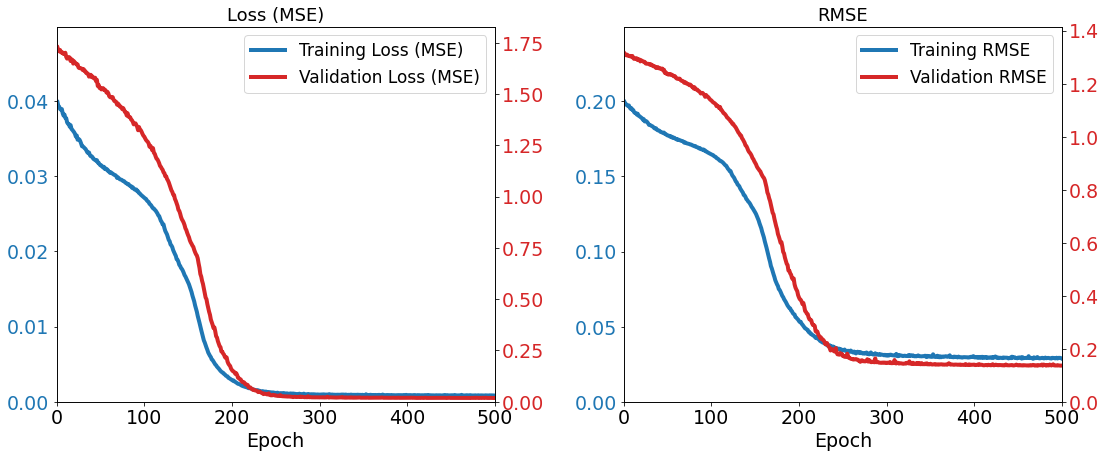

In [108]:
BTC_LSTM4DenseGaussian = BuildModel(LSTM4DenseGaussian,train_x,train_y,val_x,val_y)

In [109]:
unseen_x_15 = unseen_x[0:3:]
unseen_y_15 = unseen_y[0:3:]

## MAKE SURE YOU CHANGE MODEL NAME
reset_random_seed()
BTC_LSTM4DenseGaussian.evaluate(unseen_x_15,unseen_y_15)
predicted_values_scaled = BTC_LSTM4DenseGaussian.predict(unseen_x_15)



1/1 [==============================] - 0s 300ms/step - loss: 0.0245 - root_mean_squared_error: 0.1567


In [110]:
train_x, train_y, val_x, val_y,unseen_x,unseen_y,scaler = datawindowingskips(0.9,BTC,5,5)

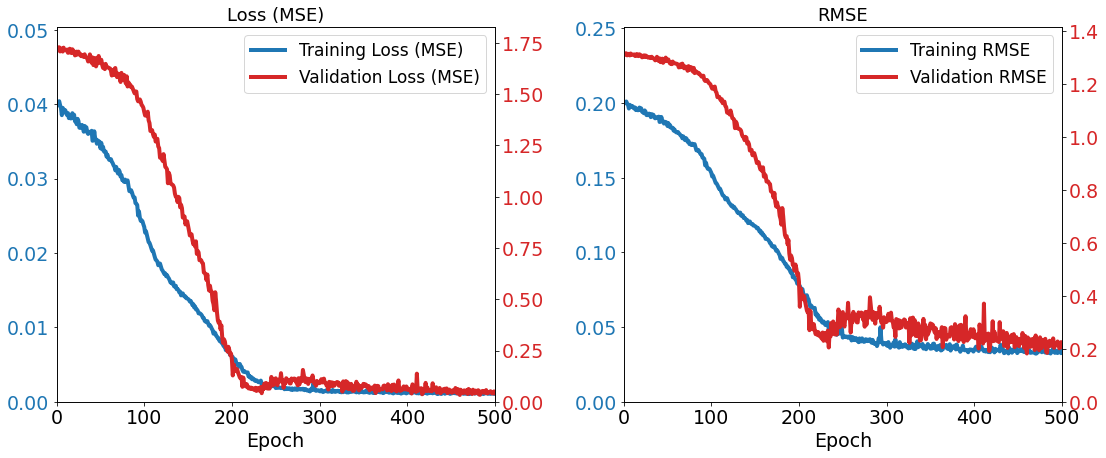

In [111]:
BTC_LSTM4DenseGaussian2 = BuildModel(LSTM4DenseGaussian2,train_x,train_y,val_x,val_y)

In [112]:
unseen_x_15 = unseen_x[0:3:]
unseen_y_15 = unseen_y[0:3:]
## MAKE SURE YOU CHANGE MODEL NAME
reset_random_seed()
BTC_LSTM4DenseGaussian2.evaluate(unseen_x_15,unseen_y_15)
predicted_values_scaled = BTC_LSTM4DenseGaussian2.predict(unseen_x_15)



1/1 [==============================] - 0s 285ms/step - loss: 0.0335 - root_mean_squared_error: 0.1829


In [113]:
unseen_y_15 = unseen_y_15.reshape(unseen_y_15.shape[0],unseen_y_15.shape[1])

In [114]:
#Get parameters to inverse scaling
smin = scaler.min_[0]
sscale = scaler.scale_[0]
sdatamin = scaler.data_min_[0]
sdatamax= scaler.data_max_[0]

scale2 = MinMaxScaler()
scale2.min_,scale2.scale_=smin,sscale

In [115]:
###INVERSE

predicted_values = scale2.inverse_transform(predicted_values_scaled)

actual_values = scale2.inverse_transform(unseen_y_15)
#actual_values
predicted_values

array([[62664.89 , 60732.812, 59603.77 , 64134.902, 63667.344],
       [54752.504, 53281.5  , 52427.42 , 56020.516, 55826.426],
       [62299.1  , 60394.004, 59274.426, 63760.523, 63311.36 ]],
      dtype=float32)

In [116]:
#testing = predicted_values.reshape(-1).tolist()

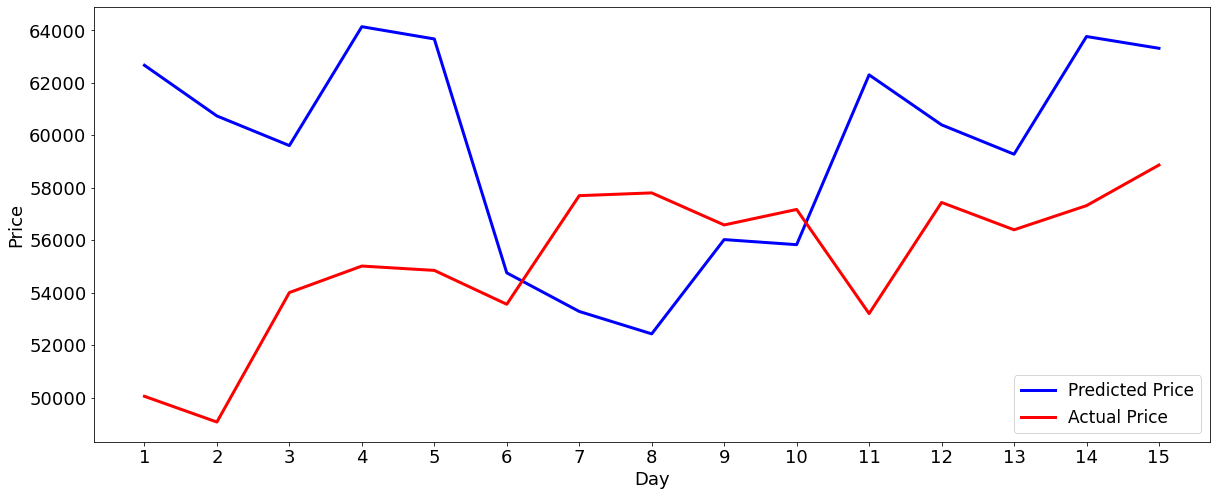

In [117]:
a = np.arange(1,16)
plt.plot(a,predicted_values.reshape(-1),label = 'Predicted Price', linewidth = 3,color = 'blue')
plt.plot(a,actual_values.reshape(-1), label = 'Actual Price', linewidth = 3, color = 'red')
plt.xlabel("Day",fontsize = 18)
plt.ylabel("Price",fontsize = 18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xticks(np.arange(1, 16, step=1))
plt.legend(loc = 4, prop={'size': 17})
plt.savefig('/Users/denis/Desktop/Masters/Dissertation/Dissertation Latex/Paper/Figures/FinalModelPredictionsBVLAH.png',transparent = False,bbox_inches='tight')

In [ ]:
#ignore

In [ ]:
train_x, train_y, val_x, val_y,unseen_x,unseen_y,scaler = datawindowingskips(0.9,BTC,5,5)

In [ ]:
BTC_LSTM4DenseGaussianval = BuildModel(LSTM4DenseGaussianTEST,train_x,train_y,val_x,val_y)